John Tweedie, 
SN:400550023,
2023-12-12,
STATS 780 Final Report

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, mean_squared_error, rand_score, silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

Chronic_Kidney_Disease - Data info:

https://www.researchgate.net/publication/328213160_Early_Stage_Chronic_Kidney_Disease_Diagnosis_by_Applying_Data_Mining_Methods_to_Urinalysis_Blood_Analysis_and_Disease_History

    age		-	age	{numeric}
    bp		-	blood pressure {numeric}
    sg		-	specific gravity {1.005,1.010,1.015,1.020,1.025}
    al		-   albumin {0,1,2,3,4,5} ***
    su		-	sugar {0,1,2,3,4,5} ***
    rbc		-	red blood cells {normal,abnormal}
    pc		-	pus cell {normal,abnormal}
    pcc		-	pus cell clumps {normal,abnormal}
    ba		-	bacteria {normal,abnormal}
    bgr		-	blood glucose random {numeric}
    bu		-	blood urea {numeric}
    sc		-	serum creatinine {numeric}
    sod		-	sodium {numeric}
    pot		-	potassium {numeric}
    hemo	-	hemoglobin {numeric}
    pcv		-	packed cell volume
    wbcc	-	white blood cell count {numeric}
    rbcc	-	red blood cell count {numeric}
    htn		-	hypertension {yes,no}
    dm		-	diabetes mellitus {yes,no}
    cad		-	coronary artery disease {yes,no}
    appet	-	appetite {good,poor}
    pe		-	pedal edema {yes,no} 
    ane		-	anemia {yes,no} 
    class	-	class {ckd,notckd}

# Data Processing

In [294]:
columns = ['age','bp','sg','al','su','rbc','pc','pcc','ba','bgr','bu','sc','sod',
           'pot','hemo','pcv','wbcc','rbcc','htn','dm','cad','appet','pe','ane','class']
numeric_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod',
           'pot','hemo','pcv','wbcc','rbcc']
blood_cols = ['bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'rbcc', 'wbcc']
urine_cols = ['sg', 'al', 'su', 'al', 'rbc', 'pc', 'pcc', 'ba']
cat_cols = [cat_col for cat_col in columns if cat_col not in numeric_cols]

In [295]:
df = pd.read_csv(r'chronic_kidney_disease.csv', header=None, names=columns)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [296]:
# data clean-up
df = df.replace('?', np.nan)
df = df.replace('\tno', 'no')
df = df.replace('\tyes', 'yes')
df = df.replace(' yes', 'yes')

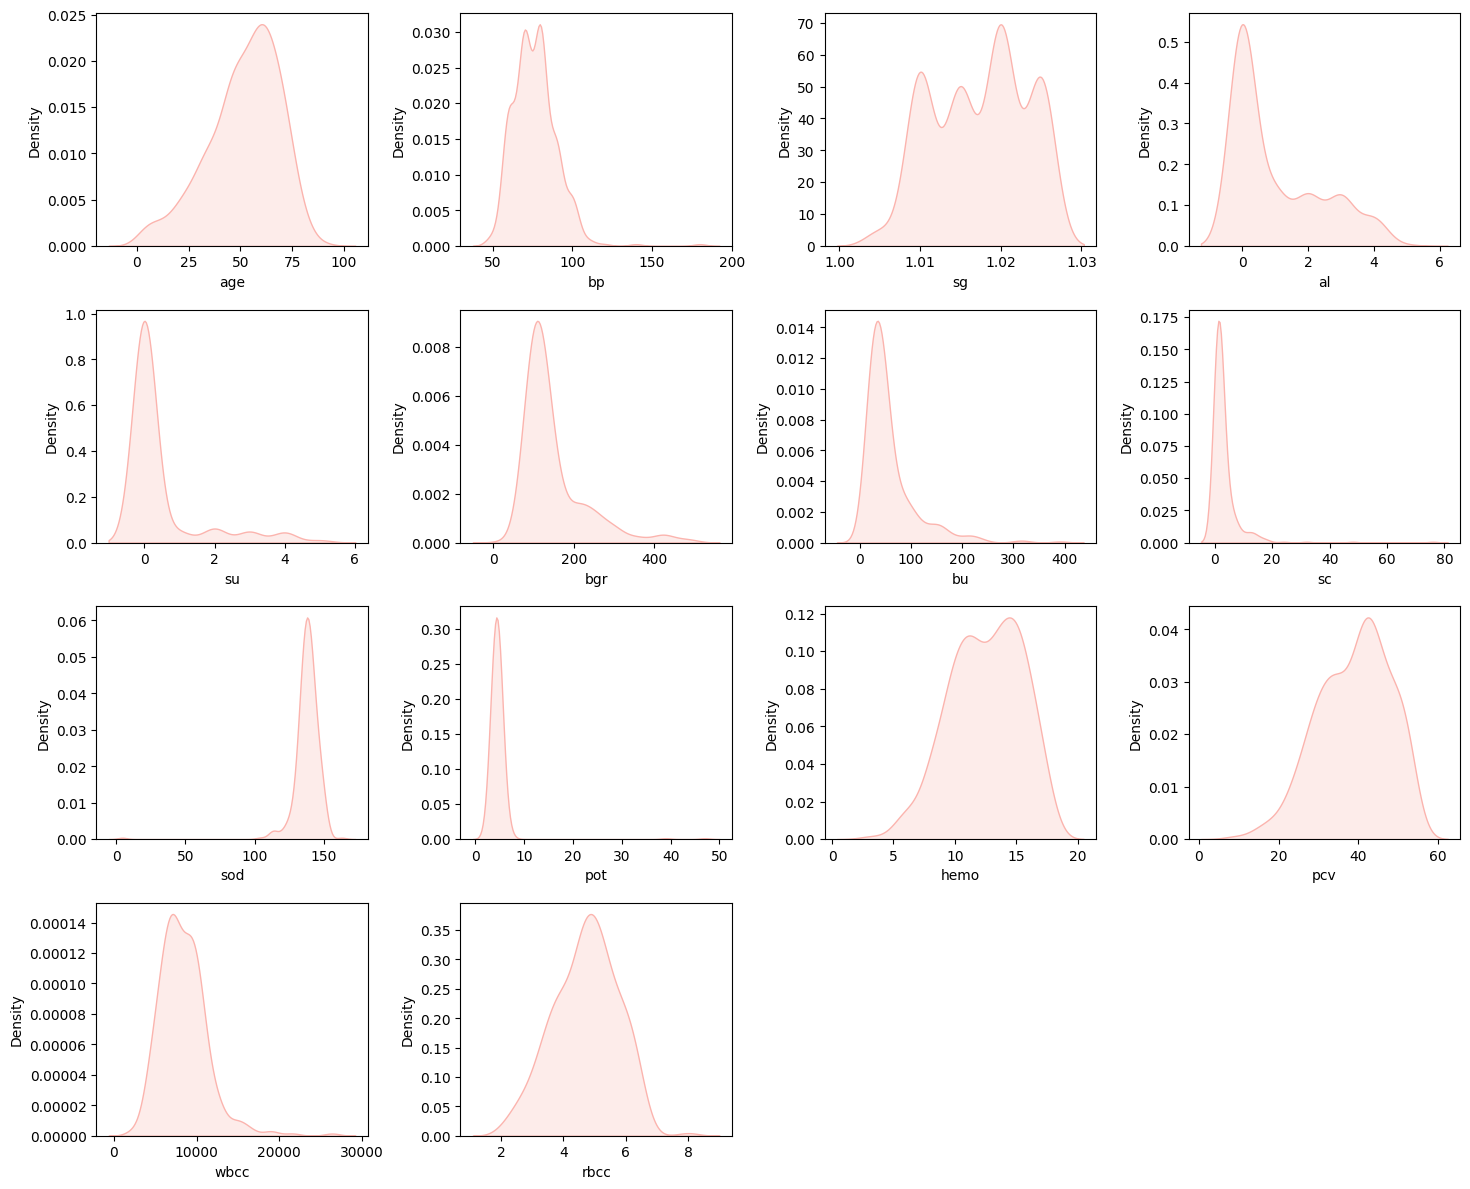

In [297]:
# KDE plots to view distributions of data
# we will check for outliers here
sns.set_palette('Pastel1')
fig, axs = plt.subplots(4, 4, figsize=(15, 12))
axs = axs.flatten()
for i, col in enumerate(df[numeric_cols].columns):
    sns.kdeplot(df[col], ax=axs[i], fill=True)
plt.tight_layout()
fig.delaxes(axs[-2])
fig.delaxes(axs[-1])

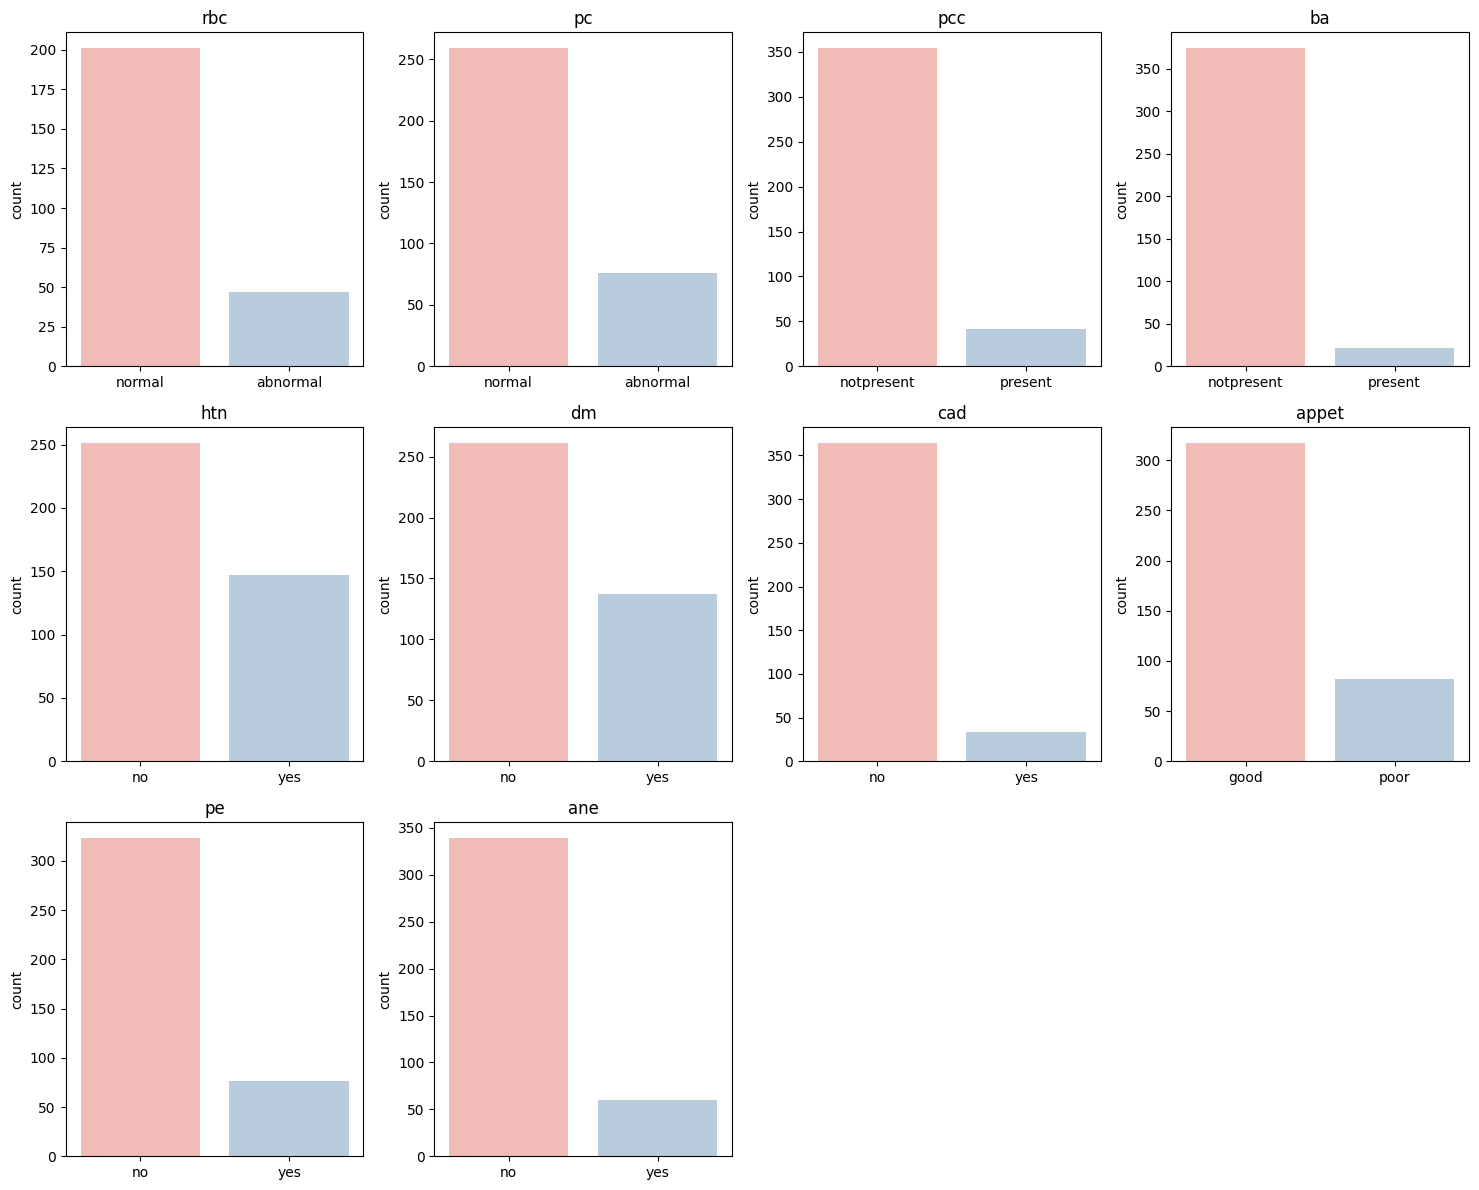

In [298]:
# Categorical data - bar plots
sns.set_palette('Pastel1')
fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.flatten()
for i, col in enumerate(df[cat_cols].columns):
    df_plot = pd.DataFrame(data=df[col].value_counts(), columns=[col])
    sns.barplot(df_plot, x=df_plot.index, y=col, ax=axs[i], errorbar=None)
    axs[i].set_ylabel('count')
    axs[i].set_xlabel('')
    axs[i].set_title(col)
plt.tight_layout()
fig.delaxes(axs[-2])
fig.delaxes(axs[-1])

In [299]:
# Outlier removal from kde and scatter plots
df = df.drop(df['pot'].nlargest(2).index) # remove visual pot outliers
df = df.drop(df['sc'].nlargest(2).index) # remove visual sc outliers

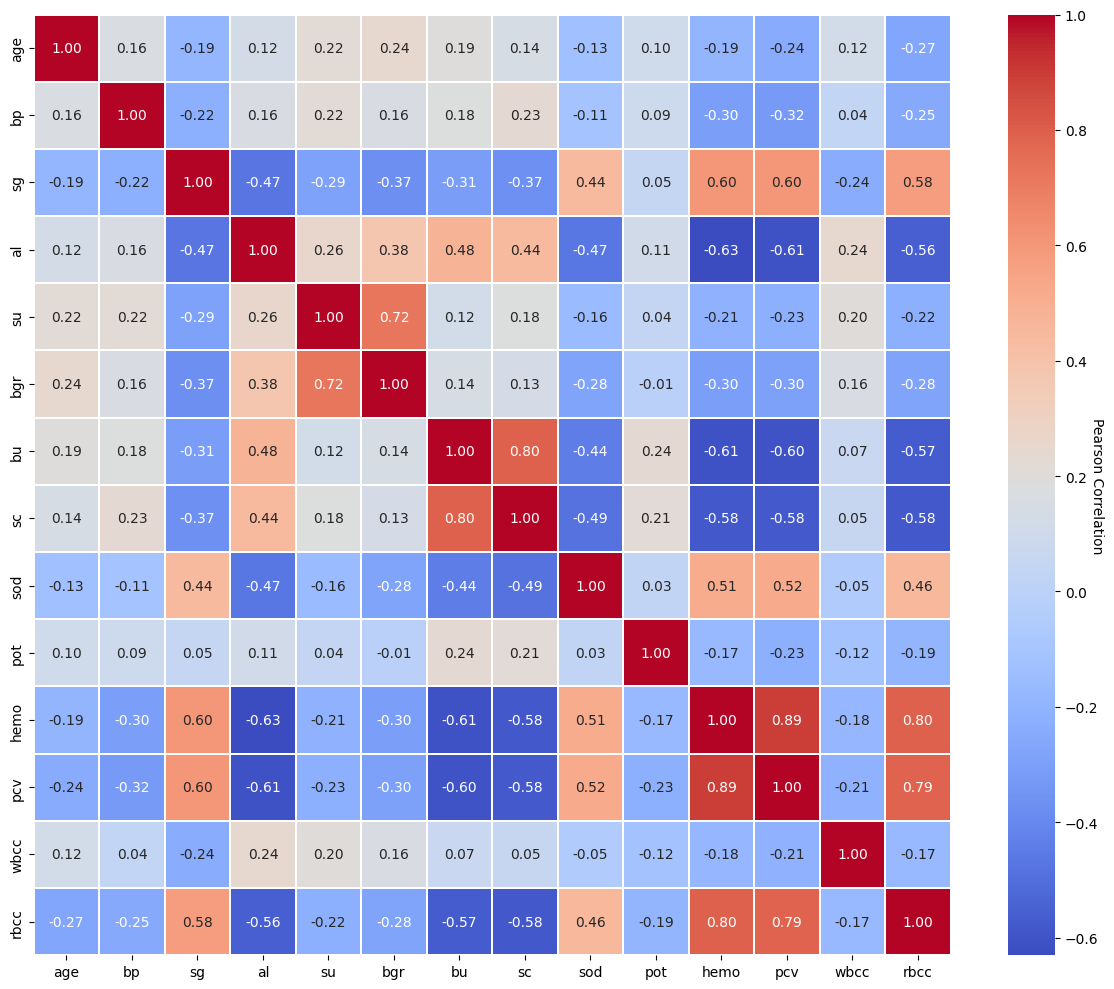

In [300]:
# correlation matrix of all variables
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, 
            cmap="coolwarm", 
            fmt=".2f", 
            linewidths=.01)
ax = plt.gca()
grad = ax.collections[0].colorbar
grad.set_label("Pearson Correlation", rotation=270)
plt.tight_layout()

## Data Processing - Categorical Data Encoding

In [301]:
# explicitly specifying the categorical enconding, rather than automatically assigning 1/0
# should help with making interpretation easier later on

# creating dictionary to specify what is a '1' or '0'
cat_dict = {'normal':1, 'abnormal':0, 'present':1, 'notpresent':0,
           'yes':1, 'no':0, 'poor':1, 'good':0, 'ckd':1, 'notckd':0}

# replace categorical values using the dictionary
df[cat_cols] = df[cat_cols].replace(cat_dict)

# convert to numeric values
df[cat_cols] = df[cat_cols].apply(pd.to_numeric, errors='coerce')

## Data Processing - Imputation of Missing Values

### Imputation by K-Nearest Neighbors for Numeric Variables
- Imputing missing numeric variables
- https://scikit-learn.org/stable/modules/impute.html

In [302]:
imputer = KNNImputer(n_neighbors=9, weights="uniform")
df_imp_num = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

### Iterative Imputation for categorical variables
- Using SKlearn's iterative imputer
    - performs a multiple regression for each columns with missing data to predict missing values, essentially logit

In [303]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [304]:
imputer = IterativeImputer(max_iter=10, random_state=13)
df_imp_cat = pd.DataFrame(np.round(imputer.fit_transform(df)), columns=df.columns)
df_imp_cat = df_imp_cat[cat_cols]

In [305]:
df = pd.concat([df_imp_num, df_imp_cat], axis=1)

Data is now appropriately imputed and fully populated - ready for modelling

## Principal Components Analysis

In [306]:
numeric_vars = ['age','bp','sg','al','su','bgr','bu',
                'sc','sod','pot','hemo','pcv','wbcc','rbcc']

scaler = StandardScaler()
# scale the numeric data and load into dataframes
df_scaled = scaler.fit_transform(df[numeric_vars]) # scale numeric only

n_pca_comps = 14
pca = PCA(n_components=n_pca_comps)
pca_fit = pca.fit_transform(df_scaled)

In [307]:
pca_cols = ['PC' + str(i) for i in range(1, 15)]
df_pca = pd.DataFrame(pca_fit, index=df.index, columns=pca_cols)

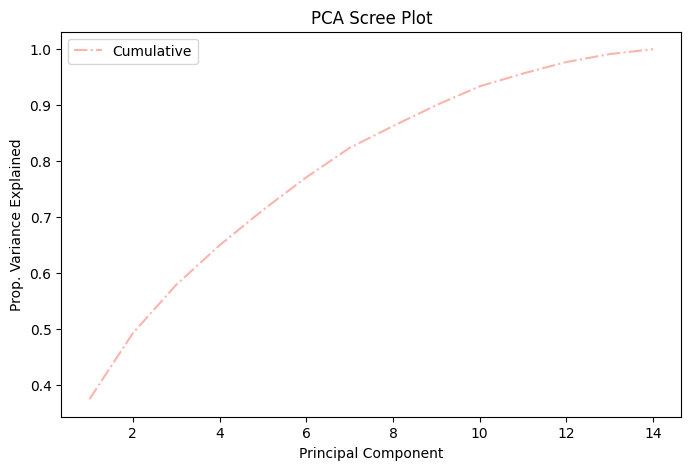

In [308]:
# Generating a cumulative scree plot
fig , ax = plt.subplots(figsize=(8,5))
prop_var_exp = pca.explained_variance_ratio_
plt.plot([i for i in range(1, 15)], np.cumsum(prop_var_exp), '-.', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Prop. Variance Explained')
plt.title('PCA Scree Plot')
plt.legend()
plt.show()

In [309]:
n_pca_comps = 3 # selecting 3 components
pca = PCA(n_components=n_pca_comps)
pca_fit = pca.fit_transform(df_scaled)
pca_cols = ['PC' + str(i) for i in range(1, n_pca_comps+1)]
df_pca = pd.DataFrame(pca_fit, index=df.index, columns=pca_cols)

## Clustering

In [310]:
# get data - standardized + encoded
df_cluster = pd.concat([(pd.DataFrame(df_scaled, index=df.index, columns=numeric_vars)),
           df[cat_cols + ['class']]], axis=1)

In [311]:
for n_km_clusters in range(2,7):
    km_cluster = KMeans(n_clusters=n_km_clusters, random_state=13, n_init=10)
#     km_cluster.fit(df_cluster)
#     km_cluster.fit(df)
    km_cluster.fit(df_pca)
    km_labels = km_cluster.labels_ # training set labels
    print('# clusters: ', n_km_clusters,
          ' Sil. Score: ', silhouette_score(df_pca, km_labels).round(2))

# clusters:  2  Sil. Score:  0.44
# clusters:  3  Sil. Score:  0.39
# clusters:  4  Sil. Score:  0.41
# clusters:  5  Sil. Score:  0.38
# clusters:  6  Sil. Score:  0.36


In [312]:
# 2 clusters has the highest silhouette score
km_cluster = KMeans(n_clusters=4, random_state=13, n_init=10)

# km_cluster.fit(df_cluster)
# km_cluster.fit(df)
km_cluster.fit(df_pca)

km_labels = km_cluster.labels_
km_centers = km_cluster.cluster_centers_

# find centroids of PCA components by cluster for plotting purposes (not true centroid of cluster)
df_pca['cluster']=km_labels
c1_center = np.mean(df_pca.loc[df_pca['cluster']==0], axis=0)
c2_center = np.mean(df_pca.loc[df_pca['cluster']==1], axis=0)
c3_center = np.mean(df_pca.loc[df_pca['cluster']==2], axis=0)
c4_center = np.mean(df_pca.loc[df_pca['cluster']==3], axis=0)

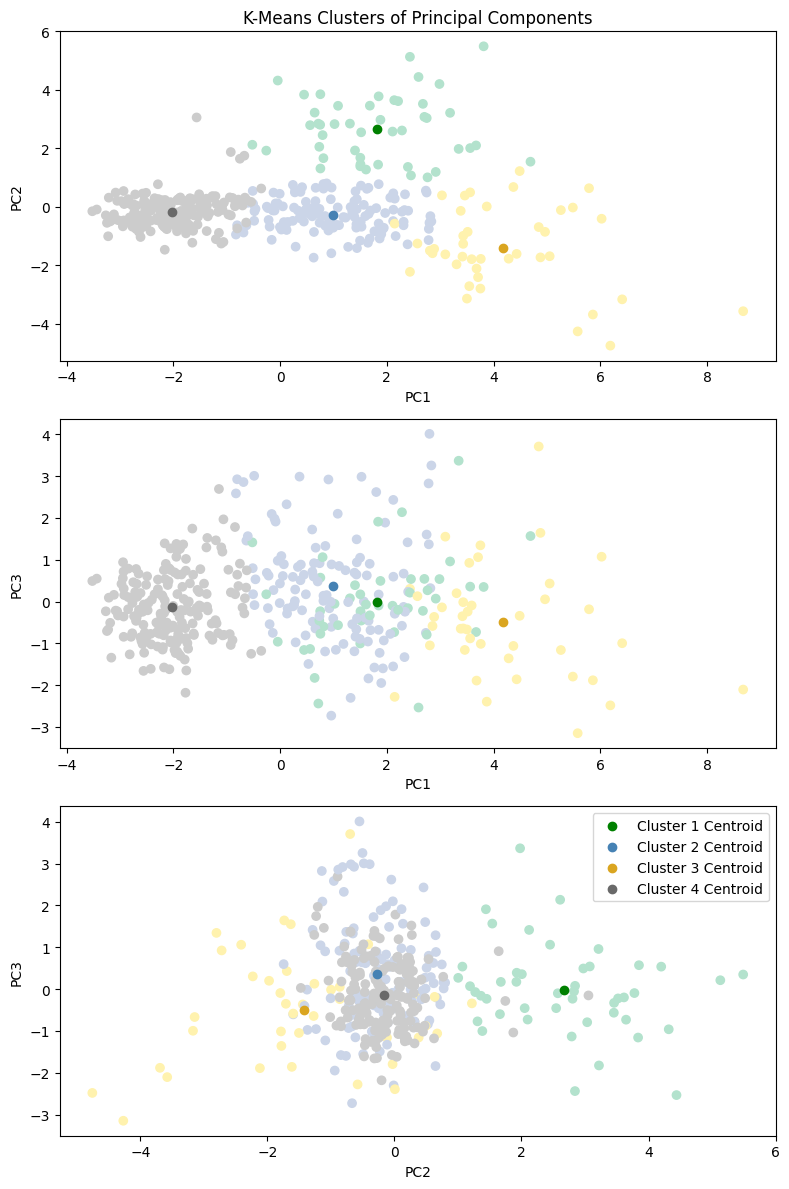

In [313]:
# plotting clusters by PCA
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs = axs.flatten()

axs[0].scatter(df_pca['PC1'], df_pca['PC2'],
        c=km_labels, cmap='Pastel2')
# axs[0].scatter(km_centers[:,0], km_centers[:,1], c='red', label='centroids')
axs[0].scatter(c1_center['PC1'], c1_center['PC2'], c='green', label='Cluster 1 Centroid')
axs[0].scatter(c2_center['PC1'], c2_center['PC2'], c='steelblue', label='Cluster 2 Centroid')
axs[0].scatter(c3_center['PC1'], c3_center['PC2'], c='goldenrod', label='Cluster 3 Centroid')
axs[0].scatter(c4_center['PC1'], c4_center['PC2'], c='dimgrey', label='Cluster 4 Centroid')
axs[0].set_title('K-Means Clusters of Principal Components')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')

axs[1].scatter(df_pca['PC1'], df_pca['PC3'],
        c=km_labels, cmap='Pastel2')
# axs[1].scatter(km_centers[:,0], km_centers[:,2], c='red', label='centroids')
axs[1].scatter(c1_center['PC1'], c1_center['PC3'], c='green', label='Cluster 1 Centroid')
axs[1].scatter(c2_center['PC1'], c2_center['PC3'], c='steelblue', label='Cluster 2 Centroid')
axs[1].scatter(c3_center['PC1'], c3_center['PC3'], c='goldenrod', label='Cluster 3 Centroid')
axs[1].scatter(c4_center['PC1'], c4_center['PC3'], c='dimgrey', label='Cluster 4 Centroid')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC3')

axs[2].scatter(df_pca['PC2'], df_pca['PC3'],
        c=km_labels, cmap='Pastel2')
# axs[2].scatter(km_centers[:,1], km_centers[:,2], c='red', label='centroids')
axs[2].scatter(c1_center['PC2'], c1_center['PC3'], c='green', label='Cluster 1 Centroid')
axs[2].scatter(c2_center['PC2'], c2_center['PC3'], c='steelblue', label='Cluster 2 Centroid')
axs[2].scatter(c3_center['PC2'], c3_center['PC3'], c='goldenrod', label='Cluster 3 Centroid')
axs[2].scatter(c4_center['PC2'], c4_center['PC3'], c='dimgrey', label='Cluster 4 Centroid')
axs[2].set_xlabel('PC2')
axs[2].set_ylabel('PC3')

plt.legend()

plt.tight_layout()

### Additional Plotting by Cluster
- useful for additional exploratory and cluster analysis/inference

In [314]:
df_clusters = df.copy() # creating a copy for plotting later
df_clusters['cluster_label'] = km_labels

In [315]:
# find CKD rates within each cluster, populate a dictionary for plotting

c1_ckd = df.loc[(df_clusters['cluster_label'] == 0) & (df_clusters['class']==1)]['class'].count()
c2_ckd = df.loc[(df_clusters['cluster_label'] == 1) & (df_clusters['class']==1)]['class'].count()
c3_ckd = df.loc[(df_clusters['cluster_label'] == 2) & (df_clusters['class']==1)]['class'].count()
c4_ckd = df.loc[(df_clusters['cluster_label'] == 3) & (df_clusters['class']==1)]['class'].count()

c1_hty = df.loc[(df_clusters['cluster_label'] == 0) & (df_clusters['class']==0)]['class'].count()
c2_hty = df.loc[(df_clusters['cluster_label'] == 1) & (df_clusters['class']==0)]['class'].count()
c3_hty = df.loc[(df_clusters['cluster_label'] == 2) & (df_clusters['class']==0)]['class'].count()
c4_hty = df.loc[(df_clusters['cluster_label'] == 3) & (df_clusters['class']==0)]['class'].count()

clusters = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']
plot_dict = {'CKD':(c1_ckd, c2_ckd, c3_ckd, c4_ckd),
           'Healthy':(c1_hty, c2_hty, c3_hty, c4_hty)}

# clusters = ['Cluster 1','Cluster 2']
# plot_dict = {'CKD':(c1_ckd, c2_ckd),
#            'Healthy':(c1_hty, c2_hty)}

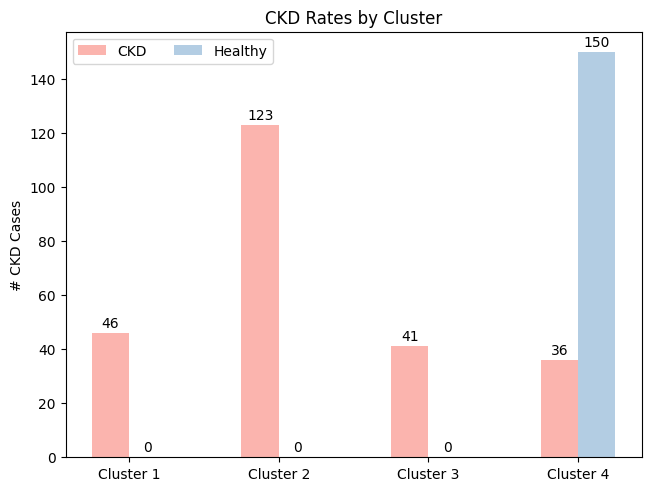

In [316]:
# bar plot to investigate difference in CKD cases
sns.set_palette('Pastel1')

x = np.arange(len(clusters))
width = 0.25
multiplier = 0.5
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in plot_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2)
    multiplier += 1
    
ax.set_ylabel('# CKD Cases')
ax.set_title('CKD Rates by Cluster')
ax.set_xticks(x + width, clusters)
ax.legend(loc='upper left', ncols=2)
plt.show()

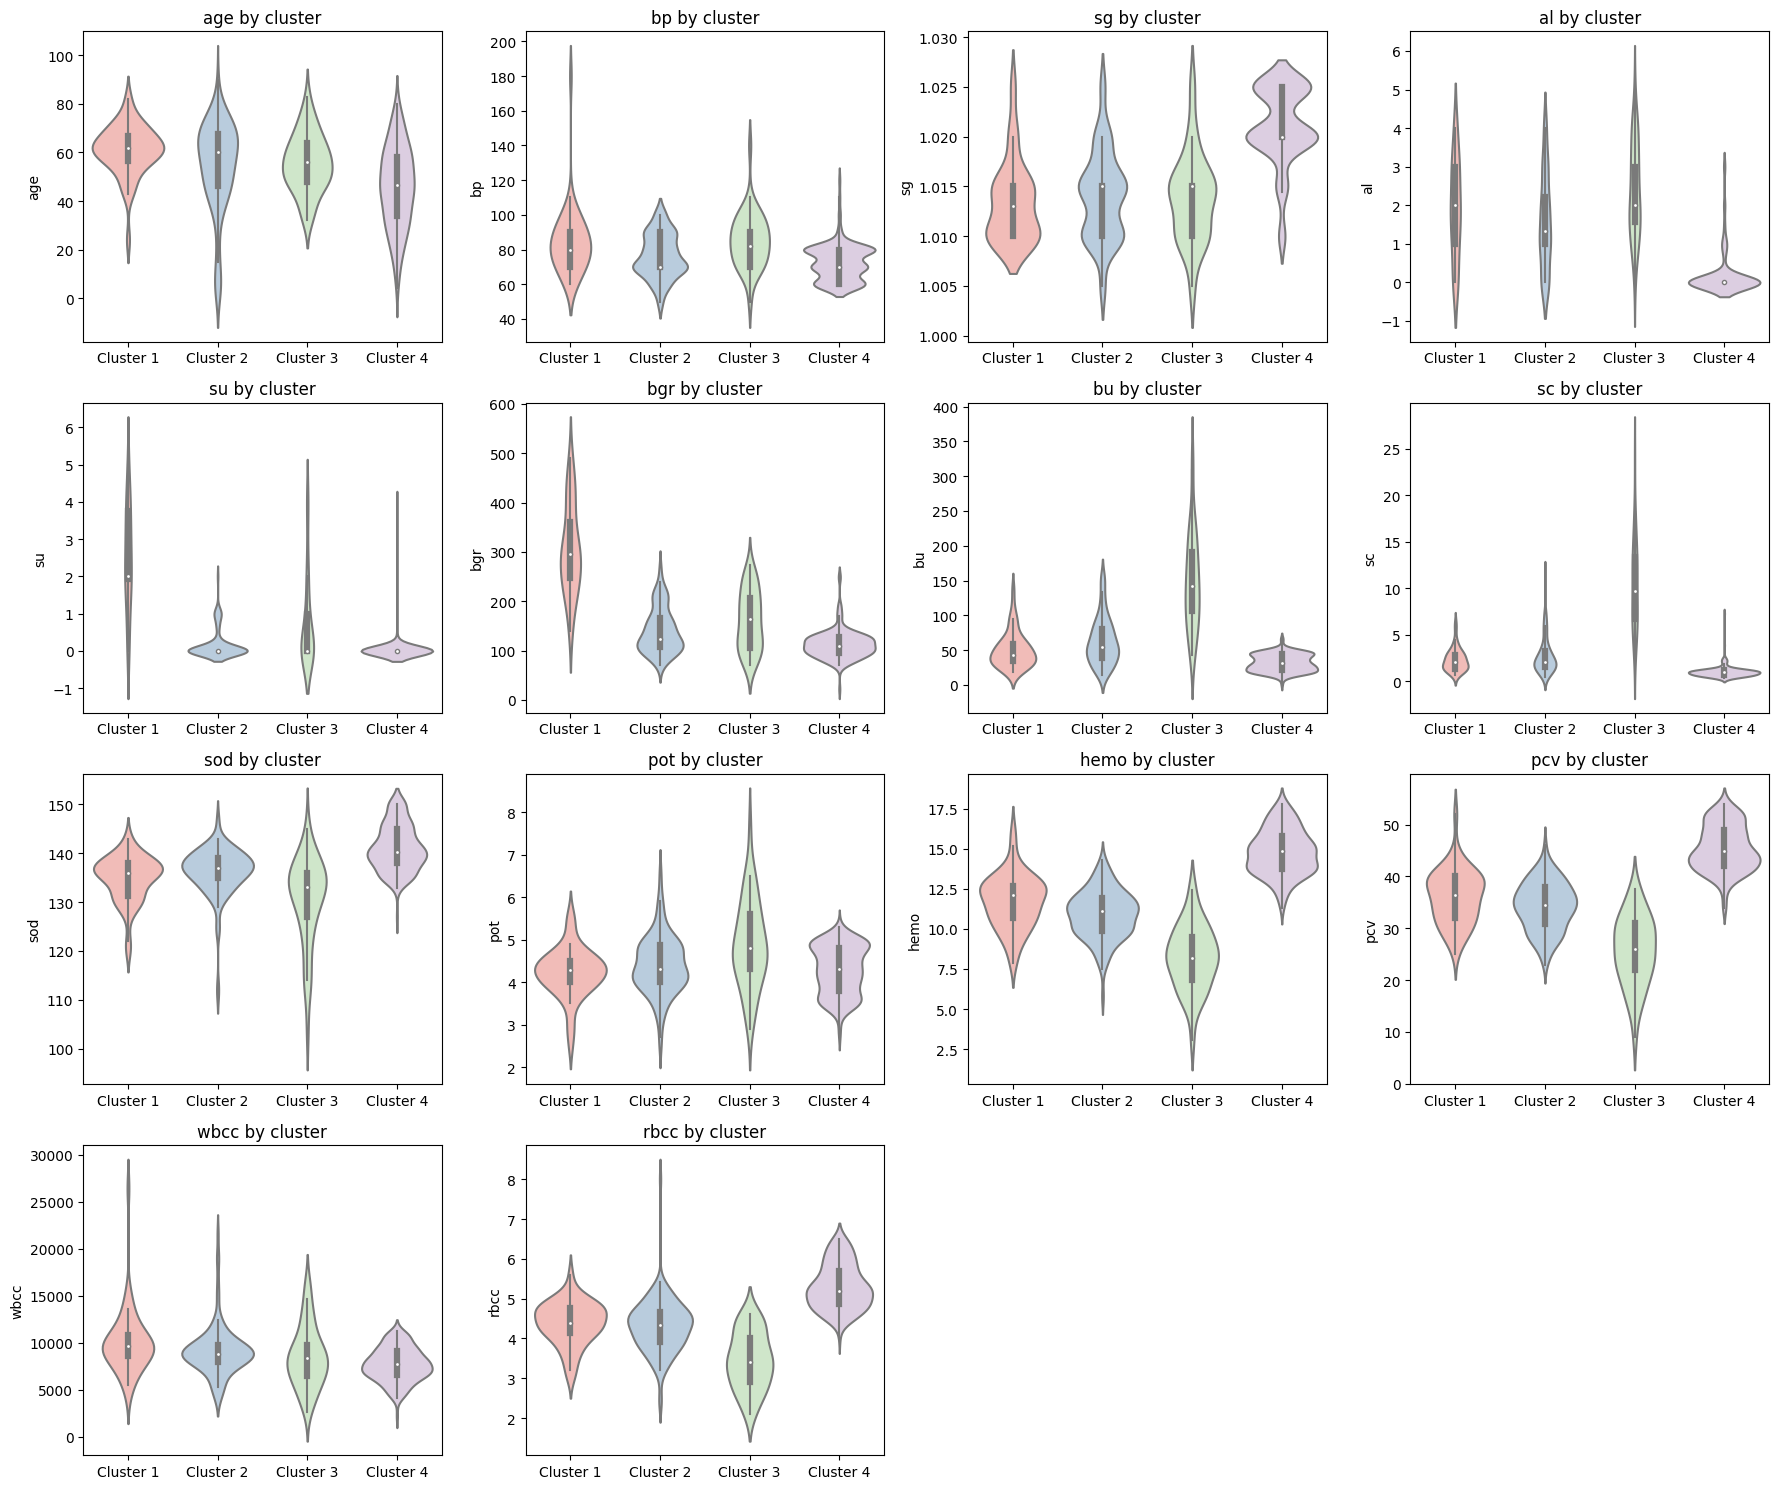

In [317]:
# create violin plots for each numeric variable, grouped by cluster
sns.set_palette('Pastel1')
fig, axs = plt.subplots(4, 4, figsize=(18, 15))
axs = axs.flatten()
for i, var in enumerate(numeric_cols):
    sns.violinplot(x='cluster_label', y=var, data=df_clusters, ax=axs[i])
    axs[i].set_title('{} by cluster'.format(var))
    axs[i].set_ylabel(var)
    axs[i].set_xticklabels(clusters)
    axs[i].set_xlabel('')
plt.tight_layout()
fig.delaxes(axs[-2])
fig.delaxes(axs[-1])
plt.show()

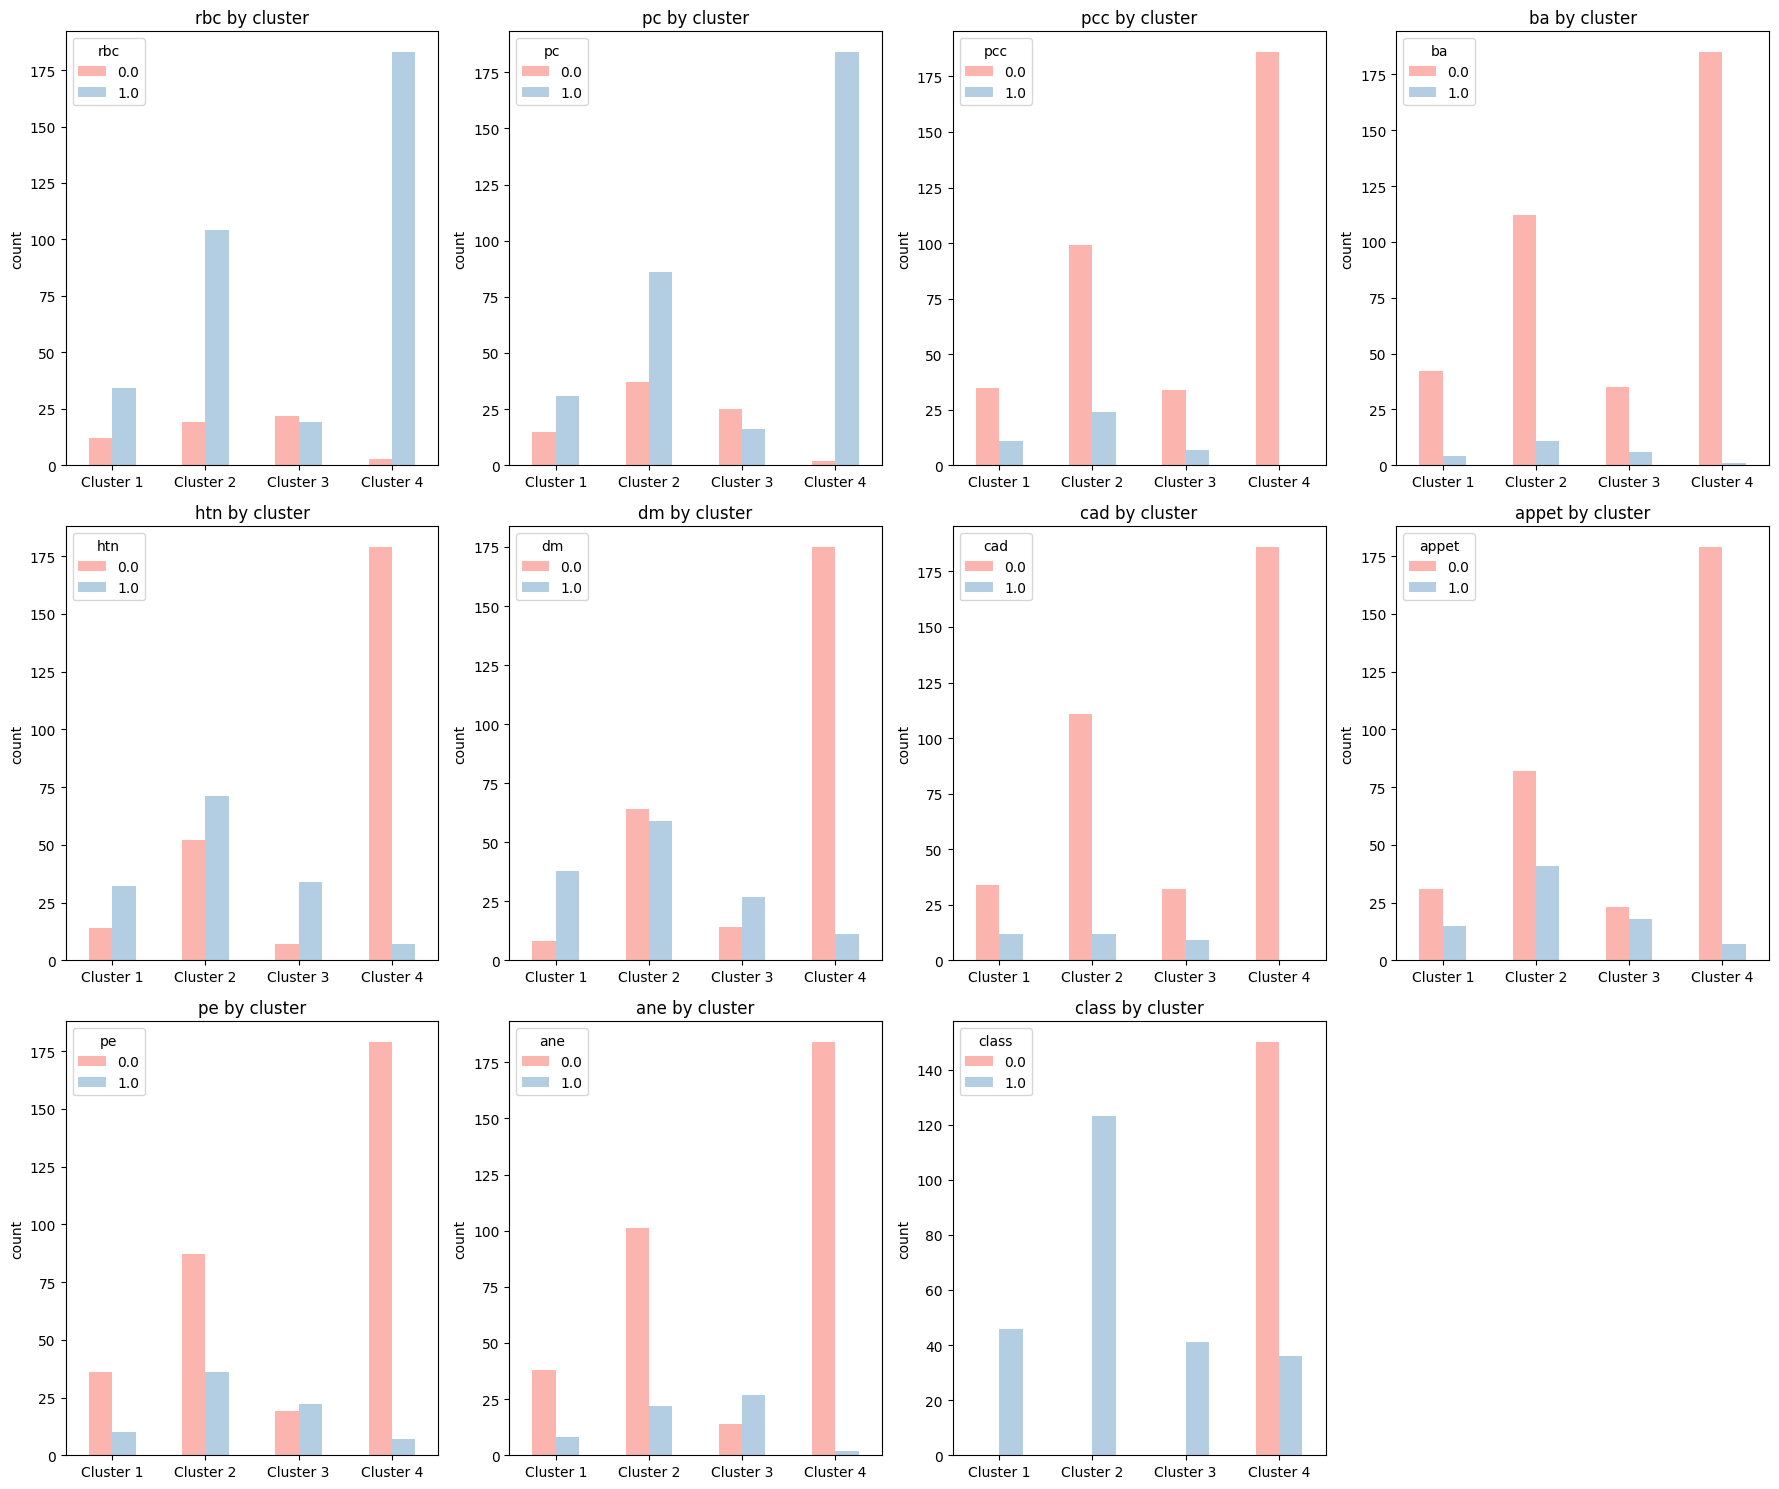

In [318]:
# create bar plots for each categorical variable, grouped by cluster

sns.set_palette('Pastel1')
fig, axs = plt.subplots(3, 4, figsize=(18, 15))
axs = axs.flatten()
for i, var in enumerate(cat_cols):
    var_count = df_clusters[cat_cols + ['cluster_label']].groupby(['cluster_label', var]).size().unstack()
    var_count.plot(kind='bar', ax=axs[i])
    axs[i].set_title('{} by cluster'.format(var))
    axs[i].set_ylabel('count')
    axs[i].set_xticklabels(clusters, rotation=0)
    axs[i].set_xlabel('')
plt.tight_layout()
fig.delaxes(axs[-1])
plt.show()

### Descriptive Statistics of Clusters

In [319]:
cluster_stats = df_clusters.groupby('cluster_label').agg(['mean', 'median', 'std'])
cluster_stats = np.round(cluster_stats, 2)
# cluster_stats = cluster_stats[cat_cols]
cluster_stats.to_csv('cluster_stats.csv')

## Test/Train Segmentation and Data Standardization

In [320]:
# re-listing out the predictor variable names, and those that are numeric vs. categorical

predictors = ['age','bp','sg','al','su','rbc','pc',
              'pcc','ba','bgr','bu','sc','sod','pot',
              'hemo','pcv','wbcc','rbcc','htn','dm',
              'cad','appet','pe','ane']

numeric_vars = ['age','bp','sg','al','su','bgr','bu',
                'sc','sod','pot','hemo','pcv','wbcc','rbcc']

cat_vars = ['rbc', 'pc', 'pcc', 'ba', 'htn', 
            'dm', 'cad', 'appet', 'pe', 'ane']

In [321]:
# Two functions to test/train split and standardize
# can pass through different subsets of variables for future feature selection, if necessary



def run_test_train_split(df, predictors):
    # function to return test train split from dataframe and predictor subset
    
    X = df[predictors]
    y = df[['class']].astype('int')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
    
    return X_train, X_test, y_train, y_test



def run_standardize(X_train, X_test, numeric_vars, cat_vars):
    # function to scale numeric dataframe columns in test and train sets
    
    scaler = StandardScaler()

    # scale the numeric data and load into dataframes
    X_train_num_scaled = scaler.fit_transform(X_train[numeric_vars]) # scale numeric only
    df_X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=numeric_vars, index=X_train.index)
    X_train = pd.concat([df_X_train_num_scaled, X_train[cat_vars]], axis=1)
    
    X_test_num_scaled = scaler.transform(X_test[numeric_vars]) # scale numeric only, using fit from train
    df_X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=numeric_vars, index=X_test.index)
    X_test = pd.concat([df_X_test_num_scaled, X_test[cat_vars]], axis=1).dropna()
    
    X_train = add_constant(X_train)
    X_test = add_constant(X_test)
    
    return X_train, X_test



X_train, X_test, y_train, y_test = run_test_train_split(df, predictors)
X_train, X_test = run_standardize(X_train, X_test, numeric_vars, cat_vars)

# Logistic Regression Classification

In [322]:
# function to print out model logistic performance (missclassification, AUC, cross-val...)

def model_performance(model, features):
    
    if 'PC1' in features:
        X_test_fs = X_test_pca[features]
    else:
        X_test_fs = X_test[features] # feature selected X_test set
    y_prob = model.predict(X_test_fs)
    
    try:
        y_pred = round(y_prob)
        con_mtx = confusion_matrix(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)
        
    except:
        con_mtx = confusion_matrix(y_test, y_prob)
        clf_report = classification_report(y_test, y_prob)
    
    print('\nCross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:')
    print('====================================================================================')
    print('\nTrue positives:', con_mtx[1][1])
    print('False positives:', con_mtx[1][0])
    print('True negatives:', con_mtx[0][0])
    print('False negatives:', con_mtx[0][1])
    print('Precision: ', round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[1][0])),3)) # ratio of true+ to total predicted
    print('Sensitivity: ', round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[0][1])),3)) # TP / (TP + FN)
    print('Specificity: ', round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[1][0])),3)) # TN / (TN + FP)
    print('Accuracy: ', round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3))
    print('Missclass. Rate: ', round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3))

    print('\nclf report: \n')
    print(clf_report)


#### Feature Selection - VIF 
 - Checks for multi-colinearity and avoids singular matrix

In [323]:
df_vif = pd.DataFrame()
df_vif['Predictor'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(len(X_train.columns))]

In [324]:
vif_drops = ['hemo', 'pcv', 'const'] # high VIF
X_train = X_train.drop(columns=vif_drops)
X_test = X_test.drop(columns=vif_drops)

In [325]:
# Fitting the full initial logisitic classsifier model
clf_lg = sm.Logit(y_train, X_train).fit(method='bfgs')
# Evaluate performance
# model_performance(clf_lg, X_train.columns)

         Current function value: 0.002622
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


### Feature Selection - Stepwise

In [326]:
# remove features based on the model fit above
fs1_drops = ['cad', 'pcc', 'pc', 'su',
             'ba', 'ane', 'rbc', 'pe', 'sod', 'pot'] # feature selection 1 drop columns
X_train = X_train.drop(columns=fs1_drops)
X_test = X_test.drop(columns=fs1_drops)

In [327]:
# Fitting the full initial logisitic classsifier model
clf_lg = sm.Logit(y_train, X_train).fit(method='bfgs')
# print(clf_lg.summary())

         Current function value: 0.040994
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


### Outlier Test - High Leverage Observations

In [328]:
# find high leverage points 
lvg = clf_lg.get_influence().hat_matrix_diag

In [329]:
# define cutoff: 'greatly exceeding' (p+1)/n (ISLP, 2023)
cutoff = (len(X_train.columns)+1) / len(lvg)
indexes = np.where(lvg > 13 * cutoff) # we will use 13 times the above, which detects 4 outliers

In [330]:
# drop high leverage points from training set
X_train = X_train.drop(X_train.index[indexes])
y_train = y_train.drop(y_train.index[indexes])

### Final 'Baseline' Logistic Regression Model

In [331]:
# Fitting the full initial logisitic classsifier model
clf_lg = sm.Logit(y_train, X_train).fit(method='bfgs')
print(clf_lg.summary())

# Evaluate performance
model_performance(clf_lg, X_train.columns)

         Current function value: 0.028616
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  233
Model:                          Logit   Df Residuals:                      221
Method:                           MLE   Df Model:                           11
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.9576
Time:                        20:22:41   Log-Likelihood:                -6.6676
converged:                      False   LL-Null:                       -157.13
Covariance Type:            nonrobust   LLR p-value:                 5.591e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -4.4795      2.848     -1.573      0.116     -10.062       1.1

## LASSO Feature Selection for Logit

In [332]:
# fit lasso_model (same as above)
lasso_model = sm.Logit(y_train, X_train)
# print(clf_lg.summary())

In [333]:
# We will perform LASSO regularization to shrink the regression coefficients
# Several tuning parameters (penalty coefficients) will be evaluated to select the best-performing model

# list of all tuning parameters to test, full coefficient shrinkage begins at ~0.005
Cs = [4, 3, 2, 1.5, 1, 0.5, 0.25, 0.1, 0.05]

# initialize dataframes
lasso_coefs = pd.DataFrame({'Feature': X_train.columns})
lasso_cv = pd.DataFrame()
lasso_model = sm.Logit(y_train, X_train)
X_test = X_test[X_train.columns]

# itterate through tuning paramters, store results in initialized dataframes
for c in Cs:
    
    clf_lasso = lasso_model.fit_regularized(method='l1', L1_wt=1, alpha=(1/c), disp=False) # alpha is the (inverse) penalty term
    y_prob = clf_lasso.predict(X_test)
    y_pred = round(y_prob)
    con_mtx = confusion_matrix(y_test, y_pred)
    
    lasso_coefs['coef_C={}'.format(c)] = clf_lasso.params.values
    
    # calculate cross validation metrics
    Precision = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[1][0])),3)
    Specificity = round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[1][0])),3)
    Sensitivity = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[0][1])),3) # TP / (TP + FN)
    Accuracy = round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3)
    Missclass = round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3)
    
    results_list = [c, con_mtx[1][1], con_mtx[1][0], con_mtx[0][0], 
                    con_mtx[0][1], Precision, Specificity, Sensitivity, Accuracy, Missclass]
    
    # store cross validation metrics in dataframe
    lasso_cv = pd.concat([lasso_cv, pd.DataFrame([results_list])], ignore_index=True)

columns=['Tuning Parameter', 'True Positives', 'False Positives', 'True Negatives',
         'False Negatives', 'Precision', 'Specificity', 'Sensitivity', 'Accuracy', 'Missclass Rate']
lasso_cv = lasso_cv.rename(columns=dict(zip(lasso_cv.columns, columns)))
lasso_coefs = lasso_coefs.set_index('Feature')

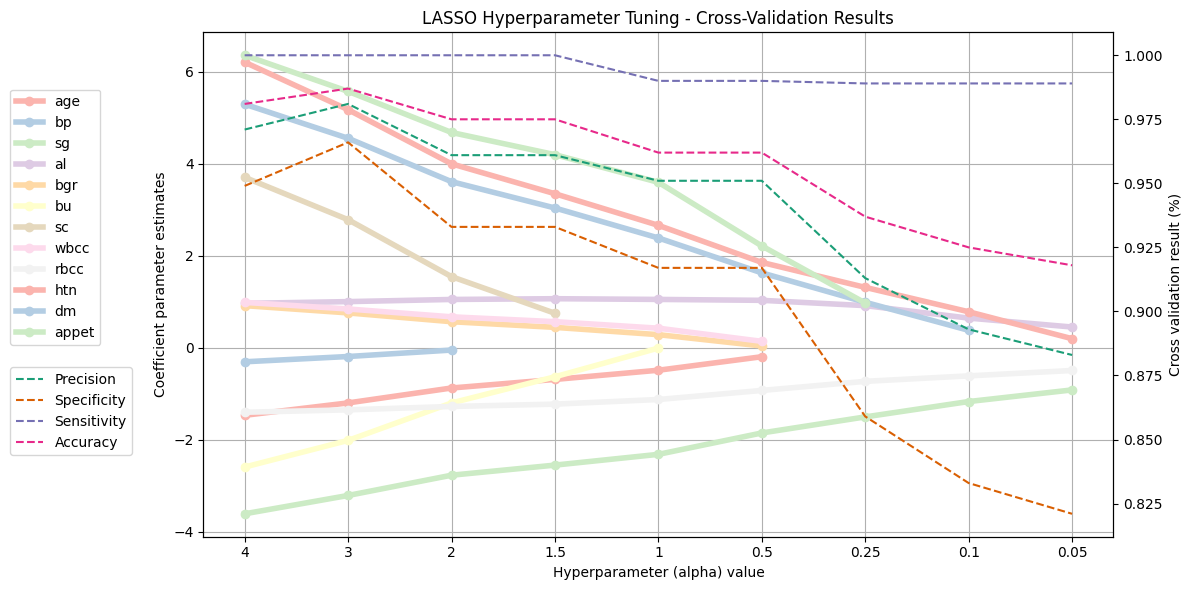

In [334]:
sns.set_palette('Pastel1')
plt.figure(figsize=(12, 6))
for col, row in lasso_coefs.replace(0, np.nan).iterrows():
    plt.plot(row, label=col, linewidth=4, marker='o')
plt.legend(loc='upper left', bbox_to_anchor=(-0.22, 0.9))
ax1 = plt.gca()
plt.grid(True)

sns.set_palette('Dark2')
ax2 = plt.gca().twinx()
for col, row in lasso_cv[['Precision', 'Specificity', 'Sensitivity', 'Accuracy']].T.iterrows():
    ax2.plot(row, linestyle='dashed', label=col)
plt.legend(loc='upper left', bbox_to_anchor=(-0.22, 0.35))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)

plt.title('LASSO Hyperparameter Tuning - Cross-Validation Results')
ax2.set_ylabel('Cross validation result (%)')
ax1.set_xticklabels(Cs)
ax1.set_ylabel('Coefficient parameter estimates')
ax1.set_xlabel('Hyperparameter (alpha) value')
plt.tight_layout()
plt.show()

In [335]:
# lasso_cv

Based on the LASSO results, we will employ a coefficient of 1.5 to achieve the best trade-off between dimensionality and accuracy, and minimizing false negative rate. However, there is no complete shrinkage of a coefficient without incurring additional false negatives

In [336]:
lasso_coefs = pd.DataFrame({'Feature': X_train.columns})
lasso_cv = pd.DataFrame()
clf_lasso = lasso_model.fit_regularized(method='l1', L1_wt=1, alpha=(1/1.5), disp=False) # alpha is the (inverse) penalty term
y_prob = clf_lasso.predict(X_test)
y_pred = round(y_prob)
con_mtx = confusion_matrix(y_test, y_pred)

lasso_coefs['coefficients'] = clf_lasso.params.values

# calculate cross validation metrics
Precision = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[1][0])),3)
Specificity = round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[1][0])),3)
Sensitivity = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[0][1])),3) # TP / (TP + FN)
Accuracy = round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3)
Missclass = round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3)

results_list = [c, con_mtx[1][1], con_mtx[1][0], con_mtx[0][0], 
                con_mtx[0][1], Precision, Specificity, Sensitivity, Accuracy, Missclass]

# store cross validation metrics in dataframe
lasso_cv = pd.concat([lasso_cv, pd.DataFrame([results_list])], ignore_index=True)

columns=['Tuning Parameter', 'True Positives', 'False Positives', 'True Negatives',
     'False Negatives', 'Precision', 'Specificity', 'Sensitivity', 'Accuracy', 'Missclass Rate']
lasso_cv = lasso_cv.rename(columns=dict(zip(lasso_cv.columns, columns)))

In [337]:
model_performance(clf_lasso, X_test.columns)
final_model = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': clf_lasso.params.values,
                           'p-value': clf_lasso.pvalues, 
                            'VIF': [variance_inflation_factor(X_test, i) for i in range(len(X_test.columns))]})




Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 99
False positives: 4
True negatives: 56
False negatives: 0
Precision:  0.961
Sensitivity:  1.0
Specificity:  0.933
Accuracy:  0.975
Missclass. Rate:  0.025

clf report: 

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        56
           1       1.00      0.96      0.98       103

    accuracy                           0.97       159
   macro avg       0.97      0.98      0.97       159
weighted avg       0.98      0.97      0.98       159



In [338]:
final_model # investigate coefficients

,Predictor,Coefficient,p-value,VIF
age,age,-0.686739,0.120526,1.169383
bp,bp,0.000000,NaN,1.243678
sg,sg,-2.549323,0.000029,1.681317
al,al,1.067900,0.080782,1.635674
bgr,bgr,0.444929,0.542992,1.337049
bu,bu,-0.628937,0.610653,2.918202
sc,sc,0.751631,0.643957,2.477935
wbcc,wbcc,0.568557,0.252254,1.199250
rbcc,rbcc,-1.223918,0.089333,2.351167
htn,htn,3.349687,0.037534,2.948019


## Logistic Regression using PCA components

In [339]:
# prepare test/train sets with PCA data

X_pca_cat = pd.concat([df_pca.drop('cluster', axis=1), df[cat_vars]], axis=1)
y = df[['class']].astype('int')
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_cat, y, test_size=0.4, random_state=100)


In [340]:
# Fitting the logisitic classsifier model using PCA components and binarys
clf_lg = sm.Logit(y_train, X_train_pca).fit(method='bfgs')
#print(clf_lg.summary())


# Evaluate performance
# model_performance(clf_lg, clf_lg.params.index)


         Current function value: 0.029428
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


In [341]:
fs1_drops = ['cad', 'dm', 'htn', 'ba', 'pe', 'ane'] # feature selection 1 drop columns
X_train_pca = X_train_pca.drop(columns=fs1_drops)
X_test_pca = X_test_pca.drop(columns=fs1_drops)

In [342]:
# Fit 2
clf_lg = sm.Logit(y_train, X_train_pca).fit(method='bfgs')
#print(clf_lg.summary())

# Evaluate performance
# model_performance(clf_lg, X_train_pca.columns)

         Current function value: 0.082415
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


In [343]:
fs1_drops = ['pc', 'pcc', 'appet', 'rbc'] # feature selection 1 drop columns
X_train_pca = X_train_pca.drop(columns=fs1_drops)
X_test_pca = X_test_pca.drop(columns=fs1_drops)

In [344]:
# Final PCA fit
clf_lg = sm.Logit(y_train, X_train_pca).fit(method='bfgs')
print(clf_lg.summary())

# Evaluate performance
model_performance(clf_lg, X_train_pca.columns)

Optimization terminated successfully.
         Current function value: 0.277946
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  237
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.5862
Time:                        20:22:42   Log-Likelihood:                -65.873
converged:                       True   LL-Null:                       -159.17
Covariance Type:            nonrobust   LLR p-value:                 3.021e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            1.4412      0.183      

# Support Vector Machine Classification

In [345]:
from sklearn import svm

In [346]:
# reset test/train dataframe
X_train, X_test, y_train, y_test = run_test_train_split(df, predictors)
X_train, X_test = run_standardize(X_train, X_test, numeric_vars, cat_vars)

# fit SVM classifier
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train['class'])
clf_svm.predict(X_test)

# cross-validation
model_performance(clf_svm, X_test.columns)


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 103
False positives: 0
True negatives: 55
False negatives: 1
Precision:  1.0
Sensitivity:  0.99
Specificity:  1.0
Accuracy:  0.994
Missclass. Rate:  0.006

clf report: 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.99      1.00      1.00       103

    accuracy                           0.99       159
   macro avg       1.00      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159



The SVM acheives near-perfect classification on the test set. 
We will test the accuracy of the SVM, but with reduced dimensions

### SVM using LASSO-selected features from L.R. model
- we will use the features that remained in the final LASSO logistic regression model to compare performance

In [347]:
coefs = final_model.dropna()
coefs = coefs['Coefficient']
fs_cols = coefs.index

In [348]:
X_train_fs1 = X_train[fs_cols]
X_test_fs1 = X_test[fs_cols]

In [349]:
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train_fs1, y_train['class'])
clf_svm.predict(X_test_fs1)
model_performance(clf_svm, X_test_fs1.columns)


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 102
False positives: 1
True negatives: 55
False negatives: 1
Precision:  0.99
Sensitivity:  0.99
Specificity:  0.982
Accuracy:  0.987
Missclass. Rate:  0.013

clf report: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       0.99      0.99      0.99       103

    accuracy                           0.99       159
   macro avg       0.99      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159



We have achieved similar, but slightly worse accuracy as the logistic regression with LASSO feature selection, while using the same set of predictor variables given from the LASSO application

### SVM using PCA

In [350]:
clf_svm.fit(X_train_pca, y_train['class'])
clf_svm.predict(X_test_pca)
model_performance(clf_svm, X_train_pca.columns)


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 102
False positives: 1
True negatives: 56
False negatives: 0
Precision:  0.99
Sensitivity:  1.0
Specificity:  0.982
Accuracy:  0.994
Missclass. Rate:  0.006

clf report: 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       1.00      0.99      1.00       103

    accuracy                           0.99       159
   macro avg       0.99      1.00      0.99       159
weighted avg       0.99      0.99      0.99       159



In [351]:
# radial and polynomial models - identical/minimially different predictions

clf_svm = svm.SVC(kernel='rbf')
clf_svm.fit(X_train, y_train['class'])
clf_svm.predict(X_test)
model_performance(clf_svm, X_test.columns)

clf_svm = svm.SVC(kernel='poly')
clf_svm.fit(X_train, y_train['class'])
clf_svm.predict(X_test)
model_performance(clf_svm, X_test.columns)


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 103
False positives: 0
True negatives: 55
False negatives: 1
Precision:  1.0
Sensitivity:  0.99
Specificity:  1.0
Accuracy:  0.994
Missclass. Rate:  0.006

clf report: 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.99      1.00      1.00       103

    accuracy                           0.99       159
   macro avg       1.00      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 103
False positives: 0
True negatives: 54
False negatives: 2
Precision:  1.0
Sensitivity:  0.981
Specificity:  1.0
Accuracy:  0.987
Missclass. Rate:  0.013

clf report: 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       

# Blood and Urinalysis-only models

### L.R. for blood test only

In [352]:
X_train_blood = X_train[blood_cols]
X_test_blood = X_test[blood_cols]

clf_lg = sm.Logit(y_train, X_train_blood).fit(method='bfgs')
# print(clf_lg.summary())

# Evaluate performance
model_performance(clf_lg, X_train_blood.columns)

         Current function value: 0.287539
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36

Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 81
False positives: 22
True negatives: 56
False negatives: 0
Precision:  0.786
Sensitivity:  1.0
Specificity:  0.718
Accuracy:  0.862
Missclass. Rate:  0.138

clf report: 

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        56
           1       1.00      0.79      0.88       103

    accuracy                           0.86       159
   macro avg       0.86      0.89      0.86       159
weighted avg       0.90      0.86      0.86       159



### L.R. for urinalysis only

In [353]:
X_train_urine = X_train[urine_cols]
X_test_urine = X_test[urine_cols]

clf_lg = sm.Logit(y_train, X_train_urine).fit(method='bfgs')
# print(clf_lg.summary())

# Evaluate performance
model_performance(clf_lg, X_train_urine.columns)

         Current function value: 0.192927
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36

Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 97
False positives: 6
True negatives: 54
False negatives: 2
Precision:  0.942
Sensitivity:  0.98
Specificity:  0.9
Accuracy:  0.95
Missclass. Rate:  0.05

clf report: 

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        56
           1       0.98      0.94      0.96       103

    accuracy                           0.95       159
   macro avg       0.94      0.95      0.95       159
weighted avg       0.95      0.95      0.95       159



### SVM for blood test only

In [354]:
clf_svm.fit(X_train_blood, y_train['class'])
clf_svm.predict(X_test_blood)
model_performance(clf_svm, X_test_blood.columns)


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 101
False positives: 2
True negatives: 41
False negatives: 15
Precision:  0.981
Sensitivity:  0.871
Specificity:  0.953
Accuracy:  0.893
Missclass. Rate:  0.107

clf report: 

              precision    recall  f1-score   support

           0       0.95      0.73      0.83        56
           1       0.87      0.98      0.92       103

    accuracy                           0.89       159
   macro avg       0.91      0.86      0.88       159
weighted avg       0.90      0.89      0.89       159



### SVM for urinalysis only

In [355]:
X_train_urine = X_train[urine_cols]
clf_svm.fit(X_train_urine, y_train['class'])
X_test_urine = X_test[urine_cols]
clf_svm.predict(X_test_urine)
model_performance(clf_svm, X_test_urine.columns)


Cross Validation Results for Chronic Kidney Disease (+) vs. Healthy (-) Precitions:

True positives: 101
False positives: 2
True negatives: 54
False negatives: 2
Precision:  0.981
Sensitivity:  0.981
Specificity:  0.964
Accuracy:  0.975
Missclass. Rate:  0.025

clf report: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        56
           1       0.98      0.98      0.98       103

    accuracy                           0.97       159
   macro avg       0.97      0.97      0.97       159
weighted avg       0.97      0.97      0.97       159



In [356]:
# complete